In [1]:
# install dependencies
!pip3 install gym --upgrade
!pip3 install pyglet
!pip3 install Box2D
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 694 kB 31.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.24.0-py3-none-any.whl size=790707 sha256=50cf1366fd1a825e93c7ed8b8218d8c13b7b3c602b1c6ace22d194b3f455b765
  Stored in directory: /root/.cache/pip/wheels/68/7a/27/ac44ac6e4763637d0ed8d89f686465960f9837440ee880abe6
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 34.8 MB/s 
Looking in indexes: https://pypi.org/simpl

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# utils

def filter(vector):
  return np.cumsum(vector)/(np.arange(0, vector.shape[0],1)+1)

In [4]:
# enviroment
import gym

env = gym.make('LunarLander-v2')
state_size =  env.observation_space.shape[0]
action_size =  env.action_space.n

print(state_size)
print(action_size)

8
4


In [5]:
# experience replay
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ExperienceReplay():
  def __init__(self, capacity) -> None:
    self.memory = deque([], maxlen=capacity)
      
  def store_transition(self, s, a, sp, r, done):
    self.memory.append((s, a, sp, r, done))
    pass

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

In [6]:
# DQN
import torch.nn as nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
  def __init__(self, state_size, action_size) -> None:
    super(DeepQNetwork, self).__init__()
    # define the architecture
    self.fc1 = nn.Linear(state_size, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, action_size)
    self.relu = nn.ReLU()
    pass

  def forward(self, x):
    # NOTE: last layer has no activation function (predict action)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

## DQN

In [7]:
# DQN agent
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DQNAgent():
  # NOTE: DON'T change initial values
  def __init__(self, state_size, action_size, batch_size,
                gamma=0.99, buffer_size=25000, alpha=1e-4):
    # network parameter
    self.state_size = state_size
    self.action_size = action_size

    # hyperparameters
    self.batch_size = batch_size
    self.gamma = gamma

    # experience replay
    self.experience_replay = ExperienceReplay(buffer_size)

    # network
    self.QNetwork = DeepQNetwork(state_size, action_size).to(device)

    # optimizer
    self.optimizer = torch.optim.Adam(self.QNetwork.parameters(), lr=alpha)
    self.criterion = nn.MSELoss()
  def take_action(self, state, eps=0.0):
    # take action using e-greedy policy
    # takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
    if random.random() < eps:
      return random.randint(0, self.action_size - 1)
    else:
      with torch.no_grad():
        q_values = self.QNetwork(torch.Tensor(state).to(device))
      return torch.argmax(q_values).item()

  def update_params(self):
    if len(self.experience_replay) < self.batch_size:
        return
    # transition batch
    batch = Transition(*zip(*self.experience_replay.sample(self.batch_size)))

    state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
    action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
    next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
    reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
    done_batch = torch.tensor(np.vstack(batch.done)).to(device)

    # calculate loss w.r.t DQN algorithm

    # STEP1
    # compute the expected Q values [y]
    with torch.no_grad():
      q_values_target = self.QNetwork(state_batch)
      q_values_next = self.QNetwork(next_state_batch)
    
    for i in range(self.batch_size):
      if done_batch[i] == True:
        q_values_target[i, action_batch[i]] = reward_batch[i]
      else:
        q_values_target[i, action_batch[i]] = reward_batch[i] + self.gamma * torch.max(q_values_next[i]).item()
        
    # STEP2
    # compute Q values [Q(s_t, a)]
    q_values_pred = self.QNetwork(state_batch)

    # STEP3
    # compute mse loss
    loss = self.criterion(q_values_pred, q_values_target)

    # optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    # NOTE: DON'T forget to set the gradients to zeros

  def save(self, fname):
    torch.save(self.QNetwork.state_dict(), fname)

  def load(self, fname, device):
    self.QNetwork.load_state_dict(torch.load(fname, map_location=device))

In [8]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

Episode 25	Average Reward: -191.29	Epsilon: 0.47
Episode 50	Average Reward: -118.59	Epsilon: 0.22
Episode 75	Average Reward: -114.63	Epsilon: 0.10
Episode 100	Average Reward: -32.51	Epsilon: 0.05
Episode 125	Average Reward: 139.84	Epsilon: 0.02
Episode 150	Average Reward: 235.97	Epsilon: 0.01
Episode 175	Average Reward: 245.12	Epsilon: 0.01
Episode 200	Average Reward: 237.91	Epsilon: 0.01
Episode 225	Average Reward: 227.43	Epsilon: 0.01
Episode 250	Average Reward: 256.53	Epsilon: 0.01
Episode 25	Average Reward: -197.04	Epsilon: 0.47
Episode 50	Average Reward: -95.57	Epsilon: 0.22
Episode 75	Average Reward: 34.13	Epsilon: 0.10
Episode 100	Average Reward: 212.29	Epsilon: 0.05
Episode 125	Average Reward: 235.06	Epsilon: 0.02
Episode 150	Average Reward: 258.98	Epsilon: 0.01
Episode 175	Average Reward: 252.43	Epsilon: 0.01
Episode 200	Average Reward: 272.67	Epsilon: 0.01
Episode 225	Average Reward: 263.43	Epsilon: 0.01
Episode 250	Average Reward: 266.02	Epsilon: 0.01
Episode 25	Average Rewa

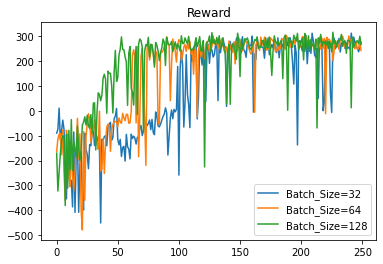

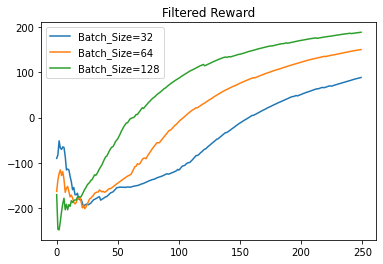

In [ ]:
# finding the best batch_size 

# create agent
batch_size_list = [32, 64, 128]
# cummulative rewards
crs = np.zeros((len(batch_size_list), n_episodes))    

for k in range(len(batch_size_list)):
  eps = 1.0
  agent = DQNAgent(state_size, action_size, batch_size_list[k],
                  gamma=0.99, buffer_size=25000, alpha=1e-4)

  crs_recent = deque(maxlen=25)                        # recent cummulative rewards

  # training loop
  for i_episode in range(1, n_episodes+1):
    # initialize the environment and state
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    while not done:
      # select and perform an action
      action = agent.take_action(state, eps)
      next_state, reward, done, _ = env.step(action)
      # store transition in experience replay
      agent.experience_replay.store_transition(state, action, next_state, reward, done)
      # update agent
      agent.update_params()
      # update current state and episode cummulative rewards
      state = next_state
      cr+=reward
    # decay epsilon
    eps = max(eps * eps_decay_rate, eps_end)
    # update current cummulative rewards and recent cummulative rewards
    crs[k, i_episode-1] = cr
    crs_recent.append(cr)
    cr = 0
    
    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

for j in range(len(batch_size_list)):
  plt.plot(crs[j, :])
plt.title('Reward')
plt.legend(['Batch_Size=32', 'Batch_Size=64', 'Batch_Size=128'])
plt.show()

def filter(vector):
  return np.cumsum(vector)/(np.arange(0, vector.shape[0],1)+1)

for j in range(len(batch_size_list)):
  plt.plot(filter(crs[j, :]))
plt.title('Filtered Reward')
plt.legend(['Batch_Size=32', 'Batch_Size=64', 'Batch_Size=128'])
plt.show()

Episode 25	Average Reward: -235.48	Epsilon: 0.47
Episode 50	Average Reward: -65.69	Epsilon: 0.22
Episode 75	Average Reward: 92.44	Epsilon: 0.10
Episode 100	Average Reward: 206.18	Epsilon: 0.05
Episode 125	Average Reward: 255.43	Epsilon: 0.02
Episode 150	Average Reward: 245.26	Epsilon: 0.01
Episode 175	Average Reward: 260.18	Epsilon: 0.01
Episode 200	Average Reward: 266.22	Epsilon: 0.01
Episode 225	Average Reward: 270.64	Epsilon: 0.01
Episode 250	Average Reward: 233.77	Epsilon: 0.01


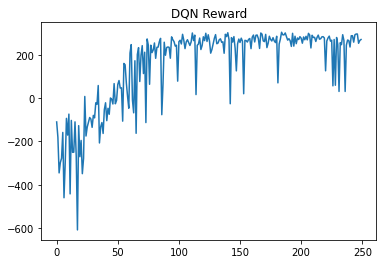

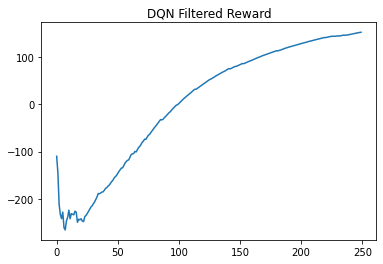

In [9]:
# training phase

# create agent
batch_size = 128
agent = DQNAgent(state_size, action_size, batch_size,
                gamma=0.99, buffer_size=25000, alpha=1e-4)

crs = np.zeros(n_episodes)     # cummulative rewards
crs_recent = deque(maxlen=25)  # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
  # initialize the environment and state
  state = env.reset()
  done = False
  cr = 0 # episode cummulative rewards
  while not done:
    # select and perform an action
    action = agent.take_action(state, eps)
    next_state, reward, done, _ = env.step(action)
    # store transition in experience replay
    agent.experience_replay.store_transition(state, action, next_state, reward, done)
    # update agent
    agent.update_params()
    # update current state and episode cummulative rewards
    state = next_state
    cr+=reward
  # decay epsilon
  eps = max(eps * eps_decay_rate, eps_end)
  # update current cummulative rewards and recent cummulative rewards
  crs[i_episode-1] = cr
  crs_recent.append(cr)
  cr = 0
  # save agent every 50 episodes
  if i_episode%50==0 or i_episode==1:
    agent.save('QNetwork'+str(i_episode)+'.pth')
  # print logs
  print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
  if i_episode % 25 == 0:
      print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

plt.plot(crs)
plt.title('DQN Reward')
plt.show()

plt.plot(filter(crs))
plt.title('DQN Filtered Reward')
plt.show()

dqn_cr = np.copy(crs)

## DDQN

In [10]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DDQNAgent():
  # NOTE: DON'T change initial values
  def __init__(self, state_size, action_size, batch_size,
              gamma=0.99, buffer_size=25000, alpha=1e-4):
    # network parameter
    self.state_size = state_size
    self.action_size = action_size

    # hyperparameters
    self.batch_size = batch_size
    self.gamma = gamma

    # experience replay
    self.experience_replay = ExperienceReplay(buffer_size)

    # networks
    self.QNetwork = DeepQNetwork(state_size, action_size).to(device)
    self.Target_QNetwork = DeepQNetwork(state_size, action_size).to(device)
    self.update_target_network()

    # optimizer
    # create adam for optimizing network's parameter (learning rate=alpha)
    # NOTE: target network parameters DOSEN'T update with optimizer
    self.optimizer = torch.optim.Adam(self.QNetwork.parameters(), lr=alpha)
    self.criterion = nn.MSELoss()

  def take_action(self, state, eps=0.0):
    # take action using e-greedy policy
    # takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
    if random.random() < eps:
      return random.randint(0, self.action_size - 1)
    else:
      with torch.no_grad():
        q_values = self.QNetwork(torch.Tensor(state).to(device))
      return torch.argmax(q_values).item() 


  def update_params(self):
    if len(self.experience_replay) < self.batch_size:
      return
    # transition batch
    batch = Transition(*zip(*self.experience_replay.sample(self.batch_size)))

    state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
    action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
    next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
    reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
    done_batch = torch.tensor(np.vstack(batch.done)).to(device)

    # calculate loss w.r.t DQN algorithm

    # STEP1
    # compute the expected Q values [y]
    with torch.no_grad():
      q_values_target = self.QNetwork(state_batch)
      q_values_next = self.Target_QNetwork(next_state_batch)
    
    for i in range(self.batch_size):
      if done_batch[i] == True:
        q_values_target[i, action_batch[i]] = reward_batch[i]
      else:
        q_values_target[i, action_batch[i]] = reward_batch[i] + self.gamma * torch.max(q_values_next[i]).item()
    # STEP2
    # compute Q values [Q(s_t, a)]
    q_values_pred = self.QNetwork(state_batch)

    # STEP3
    # compute mse loss
    loss = self.criterion(q_values_pred, q_values_target)

    # optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    # NOTE: DON'T forget to set the gradients to zeros

  def update_target_network(self):
    # copy main network parameters to target network parameters
    self.Target_QNetwork.load_state_dict(self.QNetwork.state_dict())
  
  def save(self, fname):
    torch.save(self.QNetwork.state_dict(), fname)

  def load(self, fname, device):
    self.QNetwork.load_state_dict(torch.load(fname, map_location=device))

Episode 25	Average Reward: -155.52	Epsilon: 0.47
Episode 50	Average Reward: -66.71	Epsilon: 0.22
Episode 75	Average Reward: 108.36	Epsilon: 0.10
Episode 100	Average Reward: 160.44	Epsilon: 0.05
Episode 125	Average Reward: 171.94	Epsilon: 0.02
Episode 150	Average Reward: 155.12	Epsilon: 0.01
Episode 175	Average Reward: 237.11	Epsilon: 0.01
Episode 200	Average Reward: 254.12	Epsilon: 0.01
Episode 225	Average Reward: 110.11	Epsilon: 0.01
Episode 250	Average Reward: 262.86	Epsilon: 0.01


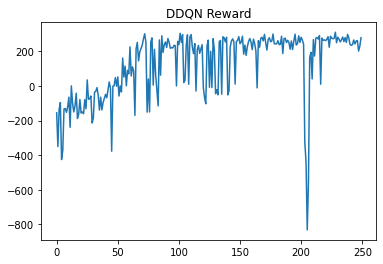

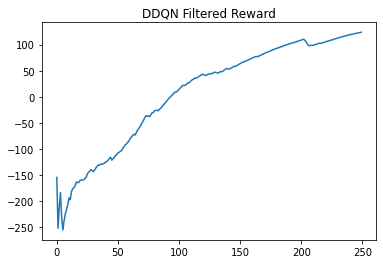

In [12]:
# training phase

# create agent
batch_size = 128
agent = DDQNAgent(state_size, action_size, batch_size,
                gamma=0.99, buffer_size=25000, alpha=1e-4)

crs = np.zeros(n_episodes)      # cummulative rewards
crs_recent = deque(maxlen=25)   # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
  # initialize the environment and state
  state = env.reset()
  done = False
  cr = 0        # episode cummulative rewards
  step = 0      # step counter
  while not done:
    # select and perform an action
    action = agent.take_action(state, eps)
    next_state, reward, done, _ = env.step(action)
    # store transition in experience replay
    agent.experience_replay.store_transition(state, action, next_state, reward, done)
    # update agent
    agent.update_params()
    if (step+1)%5 == 0:
      agent.update_target_network()
    # update current state and episode cummulative rewards
    state = next_state
    cr+=reward
    step+=1
  # decay epsilon
  eps = max(eps * eps_decay_rate, eps_end)
  # update current cummulative rewards and recent cummulative rewards
  crs[i_episode-1] = cr
  crs_recent.append(cr)
  cr = 0
  step = 0
  # save agent every 50 episodes
  if i_episode%50==0 or i_episode==1:
    agent.save('QNetwork'+str(i_episode)+'.pth')
  # print logs
  print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
  if i_episode % 25 == 0:
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

plt.plot(crs)
plt.title('DDQN Reward')
plt.show()

plt.plot(filter(crs))
plt.title('DDQN Filtered Reward')
plt.show()

ddqn_cr = np.copy(crs)

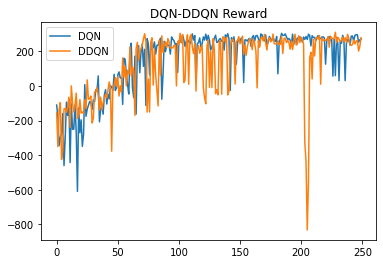

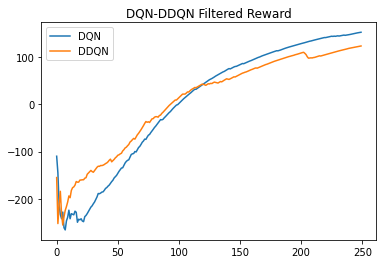

In [13]:
plt.plot(dqn_cr)
plt.plot(ddqn_cr)
plt.title('DQN-DDQN Reward')
plt.legend(['DQN', 'DDQN'])
plt.show()

plt.plot(filter(dqn_cr))
plt.plot(filter(ddqn_cr))
plt.title('DQN-DDQN Filtered Reward')
plt.legend(['DQN', 'DDQN'])
plt.show()